In [1]:
# Regular Libraries
import numpy as np
import pandas as pd

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
%matplotlib inline

# Pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Validation
from sklearn.model_selection import KFold

# Metrics
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve,
                             f1_score, auc, average_precision_score, matthews_corrcoef)

# PyTorch stuff
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# Timing
import time



# Important Values Provided by the Database
n_signal = 36499 # First n_signal rows are all signal, will have target = +1
n_bkgd = 93565 # Rest of the rows are background events, will have target = 0
n_features = 50 # Total number of features considered, are given unlabeled in the initial dataset

In [2]:
# Helper function
class ModelMetrics():
    """
        ModelMetrics class that will provide many different metrics for a given model outputs. 

        Required Parameters:
        y_test = Test Data Classes. Should be either (-1,1) or (0,1).
        y_pred = Predictions for the "probability" of y being in the positive class. Should be in range (-inf,inf)
        y_prob = Test Data Predictions from the model. Should be same format as y_test. 

        Useful functions:
        all_metrics() = returns metrics including: class imbalance, 
                                                   accuracy,
                                                   confusion matrix,
                                                   ROC/AUC,
                                                   Precision/Recall Curve, F1 score, MCC, AUC, Average Precision
        
    """
    
    def __init__(self,y_test,y_pred,y_prob):
        self.y_test = np.array(y_test).reshape(-1)
        self.y_pred = np.array(y_pred).reshape(-1)
        self.y_prob = np.array(y_prob).reshape(-1)
        
    def all_metrics(self):
        print('')
        self.imbalance()
        print('')
        self.accuracy()
        print('')
        self.print_cm()
        print('')
        self.roc_metrics()
        print('')
        self.pr_metrics()
        
    def roc_metrics(self):
        self.roc_plot()
        self.print_auc_roc()
        
    def pr_metrics(self):
        self.plot_pr()
        self.print_f1()
        self.print_mcc()
        self.print_auc_pr()
        self.print_ap()
        
    # Measure Imbalance
    def imbalance(self):
        num_examples = len(self.y_test)
        neg_val = np.min(self.y_test)
        pos_val = np.max(self.y_test)
        num_neg = np.sum(self.y_test==neg_val)
        num_pos = np.sum(self.y_test==pos_val)
        print("Number of negative cases = ",num_neg)
        print("Number of positive cases = ",num_pos)
        print('The ratio of Positve to Negative cases is {:0.3f}'.format(num_pos/num_neg))
        
        print('')
        if num_neg/num_pos >= 2:
            print('Number of Negative Classes is quite large. Recommend using the Precision-Recall Metrics.')
        elif num_pos/num_neg >=2:
            print('Number of Positive Classes is quite large. Recommend using the Precision-Recall Metrics.')
        else:
            print('The classes seem balanced. ROC metrics should be acceptable.')
        print('')
    
    # Overall accuracy
    def accuracy(self):
        acc = accuracy_score(self.y_test,self.y_pred)
        print('Overall Accuracy = {:0.3f}'.format(acc))
        return acc
        
    # Confusion Matrix
    def print_cm(self):
        cm = confusion_matrix(self.y_test,self.y_pred)
        true_negative, false_positive, false_negative, true_positive = cm.ravel()
        print('           CONFUSION MATRIX')
        print('                 y_pred')
        print('          {:^10d}{:^10d}'.format(-1,1))
        print('           --------------------')
        print('y_test -1 |{:^10d}{:^10d}|'.format(true_negative,false_positive))
        print('        1 |{:^10d}{:^10d}|'.format(false_negative,true_positive))
        print('           --------------------')
        return cm
        
    # ROC Curve
    def roc_plot(self):
        false_positive_rate, true_positive_rate, thresholds = roc_curve(self.y_test,self.y_prob)
        plt.plot(false_positive_rate,true_positive_rate,'-b',label='Model')
        plt.plot([0,1],[0,1],'-k',label='Guess')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.xlim([-0.02,1.0])
        plt.ylim([0.0,1.02])
        plt.legend()
        plt.show()

    # AUC of ROC
    def print_auc_roc(self):
        auc1 = roc_auc_score(self.y_test,self.y_prob)
        print('AUC = {:0.3f}'.format(auc1))
        return auc1

    ## These next few are more useful for imbalanced classes 

    # Precision - Recall Curve
    def plot_pr(self):
        precision, recall, thresholds = precision_recall_curve(self.y_test, self.y_prob)
        plt.plot(recall,precision,'-b',label='Model')
        plt.plot([0,1],[0.5,0.5],'-k',label='Guess')
        plt.title('Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.xlim([-0.02,1.0])
        plt.ylim([0.0,1.02])
        plt.legend()
        plt.show()

    # F1 Score
    def print_f1(self):
        f1 = f1_score(self.y_test,self.y_pred)
        print("F1 Score = {:0.3f}".format(f1))
        return f1
    
    # Matthews Correlation
    def print_mcc(self):
        mcc = matthews_corrcoef(self.y_test,self.y_pred)
        print("MCC = {:0.3f}".format(mcc))
        return mcc

    # AUC for PR
    def print_auc_pr(self):
        precision, recall, thresholds = precision_recall_curve(self.y_test, self.y_prob)
        auc2 = auc(recall,precision)
        print("AUC for Precision-Recall: {:0.3f}".format(auc2))
        return auc2

    # Average precision
    def print_ap(self):
        average_precision = average_precision_score(self.y_test,self.y_prob)
        print("Average Precision = {:0.3f}".format(average_precision))
        return average_precision

## Import Data and Visualize the Features

In [3]:
# Import Data
data = pd.read_csv('./Data/MiniBooNE_PID.txt', sep='\s+', skiprows=1,header=None)

In [4]:
# Scale and split into signal/background cases
scaler = StandardScaler()
data = data[data>-999] # Get rid of bad data, set to NA
scaler.fit(data)
data = pd.DataFrame(scaler.transform(data))

data_sig = data.iloc[0:n_signal,:].copy()
data_sig.dropna(inplace=True)
#scaler.fit(data_sig)
#data_sig = pd.DataFrame(scaler.transform(data_sig))

data_bkgd = data.iloc[n_signal:,:].copy()
#data_bkgd = data_bkgd[data_bkgd>-999]
data_bkgd.dropna(inplace=True)
#data_bkgd = pd.DataFrame(scaler.transform(data_bkgd))

In [5]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,1.295960e+05,1.295960e+05,1.295960e+05,1.295960e+05,1.295960e+05,1.295960e+05,1.295960e+05,1.295960e+05,1.295960e+05,1.295960e+05,...,1.295960e+05,1.295960e+05,1.295960e+05,1.295960e+05,1.295960e+05,1.295960e+05,1.295960e+05,1.295960e+05,1.295960e+05,1.295960e+05
mean,7.193371e-16,1.315860e-16,-1.666757e-17,6.596847e-16,-8.596955e-17,3.087886e-16,3.333513e-17,5.807331e-16,1.910629e-15,-3.982671e-16,...,-6.615489e-16,1.754481e-17,-1.579033e-17,-9.298747e-17,-6.140682e-18,-3.386148e-16,-3.158065e-17,5.263442e-18,8.070611e-17,9.035575e-17
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,...,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-4.188448e+00,-1.664962e+00,-6.934009e-01,-2.996159e+00,-1.324226e+01,-1.308249e+00,-2.829028e+00,-1.121647e+01,-4.160400e+00,-3.213869e+00,...,-3.506912e+00,-1.080709e+01,-1.976373e+00,-1.262598e+00,-3.066960e-01,-2.223482e+00,-3.268284e+01,-8.530110e+00,-8.980860e+00,-4.367990e+00
25%,-7.250524e-01,-7.089518e-01,-4.223783e-01,-6.923180e-01,-6.456758e-01,-6.057212e-01,-7.367585e-01,-5.664950e-01,-6.374142e-01,-7.030366e-01,...,-6.958432e-01,-5.357133e-01,-6.174130e-01,-5.658044e-01,-3.066960e-01,-6.999991e-01,-1.811114e-01,-7.455334e-01,-6.791240e-01,-6.240308e-01
50%,-6.074910e-02,-1.241199e-01,-1.162203e-01,-1.816575e-01,-3.440880e-01,-1.572585e-01,-1.342871e-01,1.467268e-01,-9.059995e-02,-7.192379e-02,...,7.586556e-03,7.478218e-03,-2.212209e-01,-2.711376e-01,-3.066960e-01,-1.230579e-01,2.075215e-01,-2.543917e-01,-2.461361e-01,1.599865e-02
75%,6.614412e-01,5.320069e-01,6.044764e-02,5.403607e-01,3.099178e-01,4.283842e-01,6.152670e-01,7.159347e-01,5.213595e-01,5.999610e-01,...,6.888310e-01,5.450740e-01,3.433835e-01,1.885731e-01,-2.389757e-01,5.747318e-01,4.650651e-01,4.824787e-01,3.430614e-01,6.180722e-01
max,1.050000e+01,8.495147e+00,2.505831e+01,7.617811e+00,1.358422e+01,4.418360e+00,1.536909e+01,2.352994e+00,1.437758e+01,8.030585e+00,...,5.874979e+00,5.405132e+00,3.505251e+01,1.749458e+01,1.482586e+01,5.309092e+00,2.140008e+00,9.863494e+00,1.214192e+01,7.474287e+00


In [6]:
data_sig.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,36488.000000,36488.000000,36488.000000,36488.000000,36488.000000,36488.000000,36488.000000,36488.000000,36488.000000,36488.000000,...,36488.000000,36488.000000,36488.000000,36488.000000,36488.000000,36488.000000,36488.000000,36488.000000,36488.000000,36488.000000
mean,-0.872579,-0.614196,0.137927,-0.595170,0.400434,0.654438,0.643848,0.603438,-0.487552,0.540399,...,-0.038163,0.455328,-0.082354,-0.310302,-0.215108,-0.302492,0.159270,-0.562975,-0.456920,0.141571
std,0.620062,0.885376,1.742422,0.551092,1.074011,1.272145,0.855501,0.711857,0.822318,0.936990,...,0.973105,0.806494,0.857962,0.566668,0.359574,0.688926,0.481165,0.631948,0.511851,0.851122
min,-2.391317,-1.664962,-0.693395,-2.788096,-1.190042,-1.308249,-2.163573,-4.033792,-4.160400,-2.457691,...,-3.138136,-8.738785,-1.702219,-1.262598,-0.306696,-2.223482,-9.956263,-1.832880,-4.074044,-4.367990
25%,-1.338300,-1.232655,-0.598807,-0.917873,-0.380647,-0.234807,0.057106,0.195125,-1.003378,-0.079125,...,-0.692262,0.020423,-0.630025,-0.674574,-0.306696,-0.794370,-0.016458,-1.002351,-0.799263,-0.369969
50%,-0.902549,-0.872761,-0.452247,-0.637217,0.118691,0.734656,0.615741,0.734837,-0.510043,0.479973,...,0.005556,0.404062,-0.269675,-0.422032,-0.306696,-0.393204,0.247931,-0.747823,-0.630456,0.170075
75%,-0.478399,-0.276368,0.029970,-0.339887,0.858659,1.676051,1.200881,1.120602,0.020099,1.107391,...,0.634623,0.848890,0.236016,-0.085135,-0.259206,0.073295,0.441880,-0.314938,-0.251658,0.673740
max,5.553706,6.661438,25.058311,4.758670,12.213560,4.418360,5.574570,2.352994,5.411700,7.806980,...,4.545308,5.405132,14.422114,9.963996,10.652841,4.225534,2.031047,5.410790,9.620820,4.964626


In [7]:
data_bkgd.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,93105.000000,93105.000000,93105.000000,93105.000000,93105.000000,93105.000000,93105.000000,93105.000000,93105.000000,93105.000000,...,93105.000000,93105.000000,93105.000000,93105.000000,93105.000000,93105.000000,93105.000000,93105.000000,93105.000000,93105.000000
mean,0.341961,0.240696,-0.054058,0.233219,-0.156949,-0.256466,-0.252428,-0.236494,0.191015,-0.211800,...,0.014994,-0.178459,0.032282,0.121641,0.084311,0.118618,-0.062438,0.220623,0.178913,-0.055520
std,0.908805,0.937532,0.437898,1.039047,0.923247,0.723933,0.937268,0.997355,0.998572,0.942623,...,1.009947,1.011897,1.048695,1.101607,1.147185,1.075109,1.134620,1.030797,1.083836,1.047401
min,-4.188448,-1.654476,-0.693401,-2.996159,-13.242265,-1.308249,-2.829028,-11.216474,-3.365203,-3.213869,...,-3.506912,-10.807094,-1.976373,-1.244423,-0.306696,-2.223482,-32.682844,-8.530110,-8.980860,-4.367990
25%,-0.271247,-0.391186,-0.260199,-0.473551,-0.745331,-0.657355,-0.894474,-0.776390,-0.457559,-0.862092,...,-0.696914,-0.684272,-0.611955,-0.514128,-0.306696,-0.633459,-0.273756,-0.543235,-0.534381,-0.721895
50%,0.295761,0.103796,-0.068792,0.119555,-0.470252,-0.258369,-0.402437,-0.094996,0.075472,-0.291994,...,0.008924,-0.188128,-0.200601,-0.202414,-0.306696,0.034486,0.183761,-0.016498,-0.057665,-0.061967
75%,0.908769,0.694801,0.062042,0.817171,0.029684,0.063167,0.217638,0.474503,0.687954,0.337363,...,0.710890,0.351364,0.386973,0.333245,-0.223908,0.784289,0.478176,0.748137,0.557735,0.587169
max,10.500003,8.495147,13.602909,7.617811,13.584222,4.127335,15.369092,2.191160,14.377582,8.030585,...,5.874979,5.084589,35.052513,17.494582,14.825863,5.309092,2.140008,9.863494,12.141921,7.474287


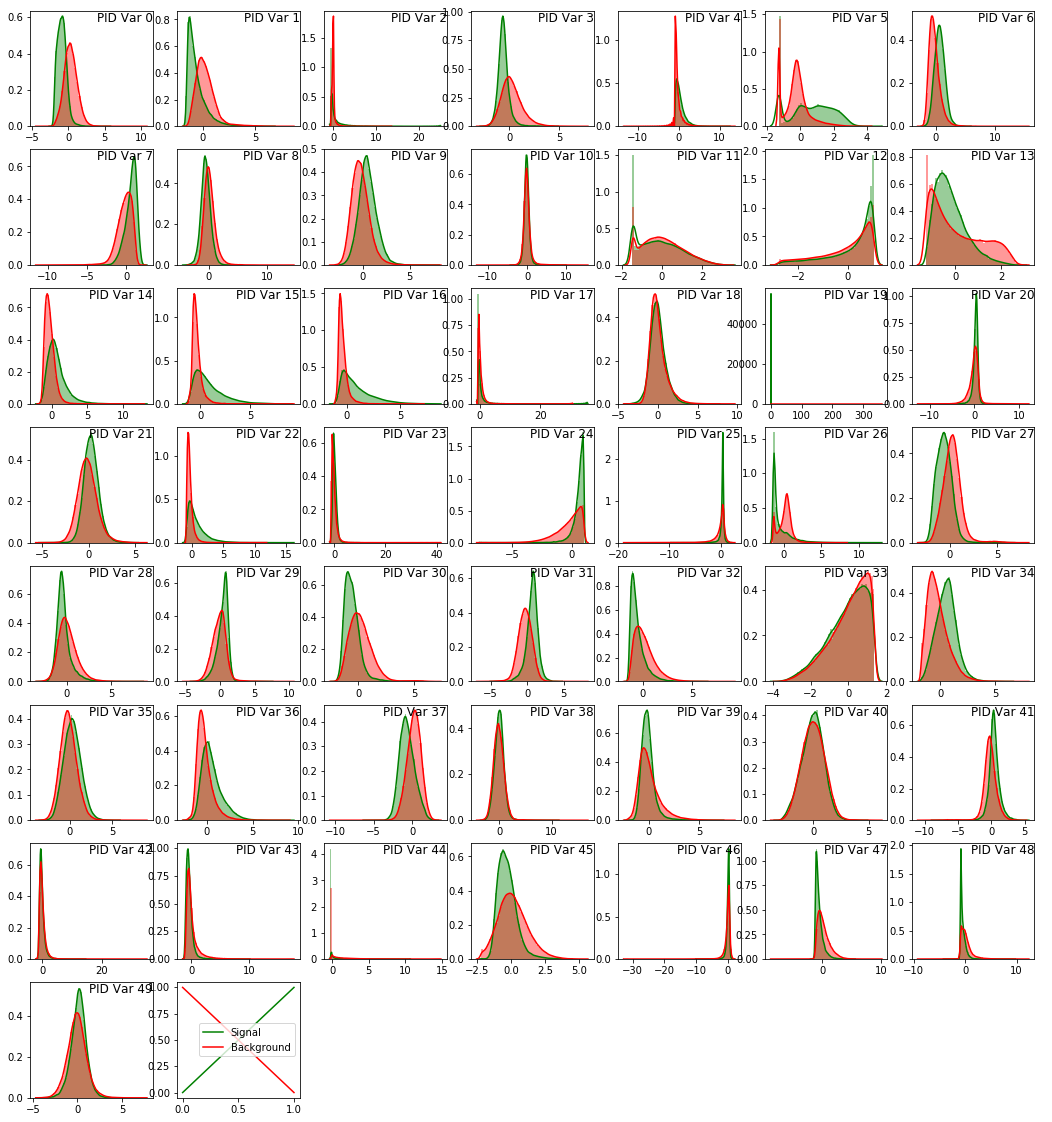

In [8]:
# Look at how the signal differs from background in the different features
f, axes = plt.subplots(8, 7, figsize=(18, 20), sharey=False)
for ii in range(8):
    for jj in range(7):
        kk = ii*7+jj
        if kk<50:
            sns.distplot(data_sig.iloc[:,kk].values,color='g',ax=axes[ii, jj],norm_hist=True)
            sns.distplot(data_bkgd.iloc[:,kk].values,color='r',ax=axes[ii, jj],norm_hist=True)
            axes[ii,jj].set_title('PID Var {:d}'.format(kk),pad=-11,loc='right')
            #axes[ii,jj].set_ylim([0,1])
        elif kk>50:
            axes[ii,jj].set_axis_off()
axes[7,1].plot([0,1],color='g')
axes[7,1].plot([1,0],color='r')
axes[7,1].legend(['Signal','Background'])
plt.show()

We can see that some of the PID variables will be more useful than others in the analysis. For example, variables 33 and 35 have almost overlapping histograms, and so will be unlikely to be useful in distinguishing background from signal. To begin, we use all the variables (as correlations between variables such as 33 and 35 may still be useful, but impossible to see in 1D histograms). 

In [9]:
# To getter a better understanding of interaction of the dimensions
# Note that this really tells us that there is a lot of mixing, can't explain with only a few variables. 

# Recombine data first (with bad data gone)

# Add a column of 1s for signal and 0s for background
n_sig_new = data_sig.shape[0]
n_bkgd_new = data_bkgd.shape[0]
data_sig = data_sig.assign(target=np.ones((n_sig_new,1)))
data_bkgd = data_bkgd.assign(target=np.zeros((n_bkgd_new,1)))
data_full = data_sig.append(data_bkgd)

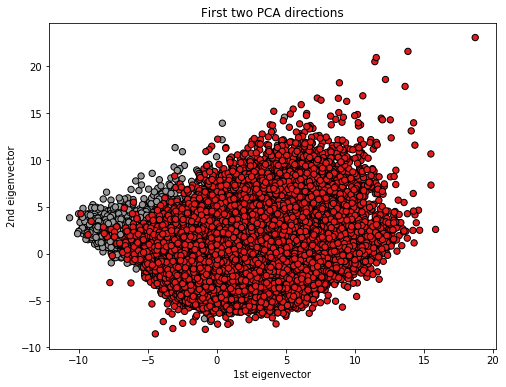

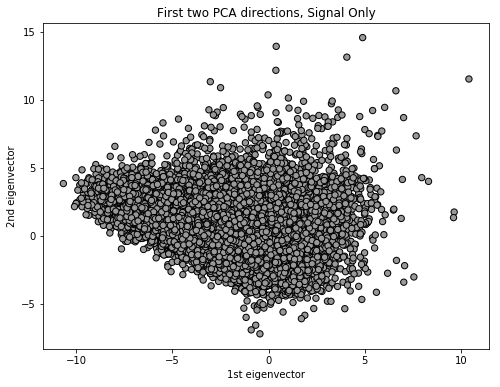

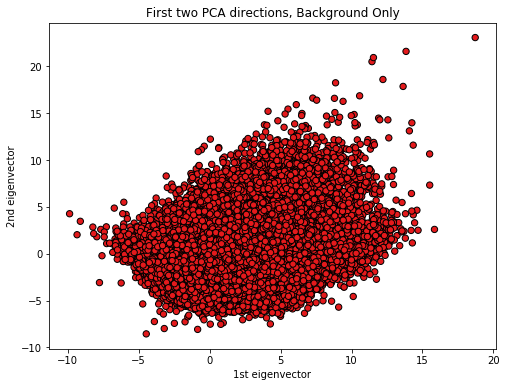

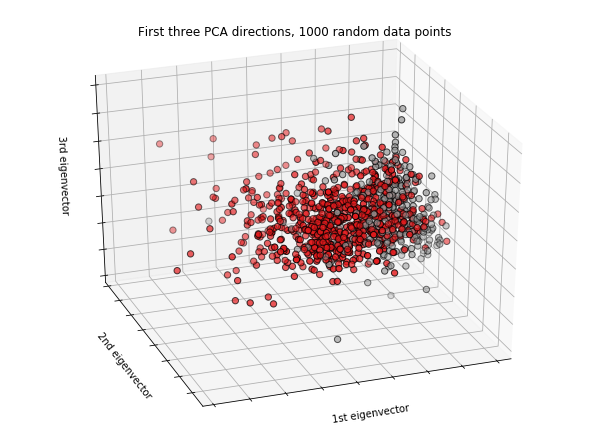

In [10]:
# plot the first three PCA dimensions
x_full = data_full.drop(['target'],axis=1).values
y_full = data_full['target'].values
fig = plt.figure(1, figsize=(8, 6))
ax = fig.gca()
#ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=2).fit_transform(x_full)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_full,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First two PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")

plt.show()

fig = plt.figure(3, figsize=(8, 6))
ax = plt.gca()
ax.scatter(X_reduced[y_full==1, 0], X_reduced[y_full==1, 1], c=y_full[y_full==1],
           cmap=plt.cm.Set1, edgecolor='k', s=40, vmin = 0)
ax.set_title("First two PCA directions, Signal Only")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")

plt.show()

fig = plt.figure(3, figsize=(8, 6))
ax = plt.gca()
ax.scatter(X_reduced[y_full==0, 0], X_reduced[y_full==0, 1], c=y_full[y_full==0],
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First two PCA directions, Background Only")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")

plt.show()


fig = plt.figure(2, figsize=(8, 6))
random_index = np.random.permutation(np.arange(x_full.shape[0]))[0:1000]
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(x_full)
ax.scatter(X_reduced[random_index, 0], X_reduced[random_index, 1],X_reduced[random_index, 2], c=y_full[random_index],
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions, {:d} random data points".format(len(random_index)))
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

We can see that the principal components are still very mixed, with none of them explaining a majority of the data. So for now, we just keep all the features as they are and feed them directly into our PyTorch Neural Nets. 

In [11]:
x_full = data_full.drop(['target'],axis=1).values
y_full = data_full['target'].values
pca = PCA(n_components=3)
pca.fit(x_full)
print("Explained variance in first 3 components: ",pca.explained_variance_ratio_)

Explained variance in first 3 components:  [0.21453388 0.11355684 0.10675532]


## Start Building Model

We will be using PyTorch to build a basic neural net to make predictions on this data. 

This is supplemented with some scikit-learn functions to train and validate. 

In [12]:
# Create a dataset class to feed into the pytorch functions
class mbData(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x)
        self.x = self.x.type(torch.FloatTensor)
        self.y = torch.tensor(y)
        self.y = self.y.type(torch.LongTensor)
        self.len = self.x.shape[0]
    def __getitem__(self,index):
        return self.x[index],self.y[index]
    def __len__(self):
        return self.len

In [13]:
# Split into train/test for validation at the end
train_data, test_data = train_test_split(data_full,test_size = 0.2,shuffle=True)

x_train = train_data.drop(['target'],axis=1).values
y_train = train_data.loc[:,'target'].values

x_test = test_data.drop(['target'],axis=1).values
y_test = test_data.loc[:,'target'].values

# Send to torch datatypes
train_set = mbData(x_train,y_train)
test_set = mbData(x_test,y_test)

# Load into dataloader
train_loader = DataLoader(dataset=train_set,batch_size=10000, shuffle=True)
test_loader = DataLoader(dataset=test_set,batch_size=10000)

test_set.x.shape[0]

25919

In [30]:
# Create Training Function

def train(model,criterion, train_loader,validation_loader, optimizer, epochs=100, print_flag = 1):
    i=0
    useful_stuff={'training_loss':[], 
                  'training_accuracy':[], 
                  'validation_loss':[], 
                  'validation_accuracy':[]
                 }  
    if print_flag>0:
        print('Training Model...')
    
    #n_epochs
    for epoch in range(epochs):
        correct_train = np.array([])
        loss_train = 0
        count = 0
        for i,(x, y) in enumerate(train_loader):
            count+=x.shape[0]
            model.train()
           
            #clear gradient 
            optimizer.zero_grad()
            #make a prediction logits 
            z=model(x)
            
            # calculate loss and accuracy
            loss=criterion(z,y)
            loss_train+=loss.data.item()
            _,label=torch.max(z,1)
            correct_train = np.hstack((correct_train,(label==y).data.numpy()))
    
            # calculate gradients of parameters 
            loss.backward()
            # update parameters 
            optimizer.step()
        
        # store useful stuff
        useful_stuff['training_loss'].append(loss_train/count)
        #useful_stuff['training_loss'].append(loss.data.item())
            
        acc_train = np.mean(correct_train)
        useful_stuff['training_accuracy'].append(acc_train)
            
            
        correct_val=np.array([])
        loss_val = 0
        count = 0
        for x, y in validation_loader:
            count+=x.shape[0]
            model.eval()
            #perform a prediction on the validation  data  
            yhat=model(x)
            loss=criterion(yhat,y)
            loss_val+=loss.data.item()
            
            _,label=torch.max(yhat,1)
            #correct+=(label==y).sum().item()
            correct_val = np.hstack((correct_val,(label==y).data.numpy()))
         
        # store useful stuff
        useful_stuff['validation_loss'].append(loss_val/count)
        
        acc_val = np.mean(correct_val)
        useful_stuff['validation_accuracy'].append(acc_val)
        
        if print_flag == 1:
            if epoch%1==0: 
                print('\r** Epoch: {:d} ** Training Loss: {:.3f} ** Training Acc: {:.3f} ** Validation Loss: {:.3f} ** Validation Acc: {:.3f} **'.format(epoch, loss_train, acc_train, loss_val, acc_val), end='')
        elif print_flag == 2:
            perc = int(np.ceil(20*epoch/epochs))+1
            print('\r['+'-'*perc+' '*(20-perc)+']',end='')
 
    if print_flag>0:
        print()
    
    return useful_stuff

To get a feel for the different types of basic models, we consider 3 different implementations:

1. No regularization.

2. Dropout Regularization.

3. Batch Normalization. 


In [18]:
# Initialize model, optimizer, etc

# Model
nH = 40
p = 0.3

# Normal
modelNormal  = nn.Sequential(
    nn.Linear(n_features,nH),
    nn.ReLU(),
    nn.Linear(nH,nH),
    nn.ReLU(),
    nn.Linear(nH,nH),
    nn.ReLU(),
    nn.Linear(nH,2)
)

# Dropout
modelDropOut = nn.Sequential(
    nn.Linear(n_features,nH),
    nn.Dropout(p=p),
    nn.ReLU(),
    nn.Linear(nH,nH),
    nn.Dropout(p=p),
    nn.ReLU(),
    nn.Linear(nH,nH),
    nn.Dropout(p=p),
    nn.ReLU(),
    nn.Linear(nH,2)
)

# Batchnorm
modelBatchNorm = nn.Sequential(
    nn.Linear(n_features,nH),
    nn.BatchNorm1d(nH),
    nn.ReLU(),
    nn.Linear(nH,nH),
    nn.BatchNorm1d(nH),
    nn.ReLU(),
    nn.Linear(nH,nH),
    nn.BatchNorm1d(nH),
    nn.ReLU(),
    nn.Linear(nH,2)
)

model = modelNormal

# optimizer
optimizerNormal = torch.optim.Adam(modelNormal.parameters(), lr=0.1)
optimizerBatch = torch.optim.Adam(modelBatchNorm.parameters(), lr=0.1)
optimizerDrop = torch.optim.Adam(modelDropOut.parameters(), lr=0.1)

# criterion
criterion = torch.nn.CrossEntropyLoss()

In [21]:
epochs = 20
print('Normal')
training_results1=train(modelNormal,criterion, train_loader,test_loader, optimizerNormal, epochs=epochs,print_flag=2)
print('\nDrop Out')
training_results2=train(modelDropOut,criterion, train_loader,test_loader, optimizerDrop, epochs=epochs, print_flag=2)
print('\nBatch Norm')
training_results3=train(modelBatchNorm,criterion, train_loader,test_loader, optimizerBatch, epochs=epochs, print_flag=2)

Normal
Training Model...
[------------------- ]

Drop Out
Training Model...
[------------------- ]

Batch Norm
Training Model...
[------------------- ]


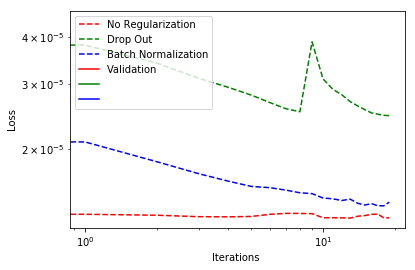

In [22]:
plt.plot(training_results1['training_loss'], '--r', label='No Regularization')
plt.plot(training_results2['training_loss'], '--g', label='Drop Out')
plt.plot(training_results3['training_loss'], '--b', label='Batch Normalization')
plt.plot(training_results1['validation_loss'], '-r', label='Validation')
plt.plot(training_results2['validation_loss'], '-g', label = ' ')
plt.plot(training_results3['validation_loss'], '-b', label= ' ')
plt.ylabel('Loss')
plt.xlabel('Iterations ')   
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

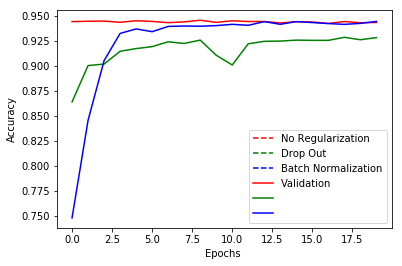

In [23]:
plt.plot(training_results1['training_accuracy'], '--r', label='No Regularization')
plt.plot(training_results2['training_accuracy'], '--g', label='Drop Out')
plt.plot(training_results3['training_accuracy'], '--b', label='Batch Normalization')
plt.plot(training_results1['validation_accuracy'], '-r', label='Validation')
plt.plot(training_results2['validation_accuracy'], '-g', label = ' ')
plt.plot(training_results3['validation_accuracy'], '-b', label= ' ')
plt.ylabel('Accuracy')
plt.xlabel('Epochs ')   
plt.legend()
plt.show()

It looks like the batch normalization does the best job, so let's look closer at the results for this method on the test data set. But first let's optimize our hyperparameters using cross-validation.

These include:

* batchsize
* learning rate 
* number of epochs
* number of hidden layers
* size of hidden layers

Because the models train fairly slow, let's just focus on a few different options. 

In [24]:
n_folds = 3

batchsize_list = [10000]
learning_rate_list = [0.1]
n_epochs_list = [25, 50, 75]
n_hidden_list = [2, 3, 4, 5]
n_hidden_size_list = [25, 50, 75]

total_models = len(batchsize_list)*len(learning_rate_list)*len(n_epochs_list)*len(n_hidden_list)*len(n_hidden_size_list)

output_dict = {
    'batchsize':[],
    'learning_rate':[],
    'n_epochs':[],
    'n_hidden':[],
    'n_hidden_size':[],
    'average_loss':[],
    'average_accuracy':[]
}

best_batchsize = 0
best_learning_rate = 0
best_n_epochs = 0
best_n_hidden = 0
best_n_hidden_size = 0
best_acc = 0
best_model = 0

model_number = 1

kf = KFold(n_splits=n_folds, shuffle=True)
index_list = np.arange(0,len(x_train))
global_start = time.time()
for batchsize in batchsize_list:
    for learning_rate in learning_rate_list:
        for n_epochs in n_epochs_list:
            for n_hidden in n_hidden_list:
                for n_hidden_size in n_hidden_size_list:
                    
                    acc = []
                    split = 1
                    start = time.time()
                    end = time.time()
                    print_str = '\r'
                    print_str += '** Model {:d}/{:d}:'.format(model_number,total_models)
                    print_str += ' ** ['+'-'*split+' '*(n_folds-split)+']'
                    print_str += ' ** Current Best Model: {:d} ** Accuracy: {:.3f}'.format(best_model, best_acc)
                    print_str += ' ** Model Time: {:.3f} ** Total Time: {:.3f} **'.format(end-start,end-global_start)
                    print(print_str,end='')
                    for train_index, val_index in kf.split(index_list):

                        kv_x_train = x_train[train_index,:]
                        kv_y_train = y_train[train_index]
                        kv_x_val = x_train[val_index,:]
                        kv_y_val = y_train[val_index]

                        kv_train_set = mbData(kv_x_train,kv_y_train)
                        kv_val_set = mbData(kv_x_val,kv_y_val)
                        
                        kv_train_loader = DataLoader(dataset=kv_train_set,batch_size=batchsize, shuffle=True)
                        kv_val_loader = DataLoader(dataset=kv_val_set,batch_size=10000)

                        # Batchnorm - build appropriate size
                        modules = []
                        modules.append(nn.Linear(n_features,n_hidden_size))
                        modules.append(nn.BatchNorm1d(n_hidden_size))
                        modules.append(nn.ReLU())
                        
                        for ii in range(n_hidden-1):
                            modules.append(nn.Linear(n_hidden_size,n_hidden_size))
                            modules.append(nn.BatchNorm1d(n_hidden_size))
                            modules.append(nn.ReLU())
                            
                        modules.append(nn.Linear(n_hidden_size,2))
                        
                        model = nn.Sequential(*modules)

                        # optimizer
                        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                        # criterion
                        criterion = torch.nn.CrossEntropyLoss()
                        
                        # train model
                        results = train(model,criterion, kv_train_loader, kv_val_loader, optimizer, epochs=n_epochs, print_flag=0)
                        
                        # determine validation accuracy
                        acc.append(results['validation_accuracy'][-1])
                        
                        split+=1
                        
                        end=time.time()
                        print_str = '\r'
                        print_str += '** Model {:d}/{:d}:'.format(model_number,total_models)
                        print_str += ' ** ['+'-'*split+' '*(n_folds-split)+']'
                        print_str += ' ** Current Best Model: {:d} ** Accuracy: {:.3f}'.format(best_model, best_acc)
                        print_str += ' ** Model Time: {:.3f} ** Total Time: {:.3f} **'.format(end-start,end-global_start)
                        print(print_str,end='')
                        
                    end = time.time()
                    accuracy = np.mean(acc)
                    
                    if accuracy>best_acc:
                        best_batchsize = batchsize
                        best_learning_rate = learning_rate
                        best_n_epochs = n_epochs
                        best_n_hidden = n_hidden
                        best_n_hidden_size = n_hidden_size
                        best_acc = accuracy
                        best_model = model_number
                    
                    print_str = '\r'
                    print_str += '** Model {:d}/{:d}:'.format(model_number,total_models)
                    print_str += ' ** ['+'-'*split+' '*(n_folds-split)+']'
                    print_str += ' ** Current Best Model: {:d} ** Accuracy: {:.3f}'.format(best_model, best_acc)
                    print_str += '** Model Time: {:.3f} ** Total Time: {:.3f}'.format(end-start,end-global_start)
                    print(print_str,end='')
                    
                    model_number+=1
                        

                        

Model 35/36: [----] Current Best Model: 14 Accuracy: 0.946Model Time: 699.883 Total Time: 11151.425

In [28]:
print('Best Model Parameters:')
print('-----------------------')
print('Batch Size:      ', best_batchsize)
print('Learning Rate:   ', best_learning_rate)
print('Epochs:          ', best_n_epochs)
print('Number of Layers:',best_n_hidden)
print('Length of Layer: ',best_n_hidden_size)
print('Accuracy:        ',best_acc)

Best Model Parameters:
-----------------------
Batch Size:       10000
Learning Rate:    0.1
Epochs:           50
Number of Layers: 2
Length of Layer:  75
Accuracy:         0.9455987036286823


In [31]:
# Use best parameters to make final model


# Batchnorm - build appropriate size
modules = []
modules.append(nn.Linear(n_features,best_n_hidden_size))
modules.append(nn.BatchNorm1d(best_n_hidden_size))
modules.append(nn.ReLU())

for ii in range(best_n_hidden-1):
    modules.append(nn.Linear(best_n_hidden_size,best_n_hidden_size))
    modules.append(nn.BatchNorm1d(best_n_hidden_size))
    modules.append(nn.ReLU())

modules.append(nn.Linear(best_n_hidden_size,2))

model = nn.Sequential(*modules)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate)

# criterion
criterion = torch.nn.CrossEntropyLoss()

# train model
results = train(model,criterion,train_loader, test_loader, optimizer, epochs=best_n_epochs, print_flag=1)


Training Model...
** Epoch: 49 ** Training Loss: 1.270 ** Training Acc: 0.955 ** Validation Loss: 0.423 ** Validation Acc: 0.945 **


## Look at Final Results

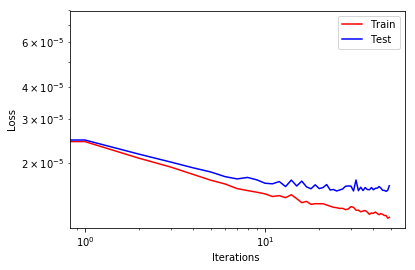

In [32]:
plt.plot(results['training_loss'], '-r', label='Train')
plt.plot(results['validation_loss'], '-b', label= 'Test')
plt.ylabel('Loss')
plt.xlabel('Iterations ')   
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

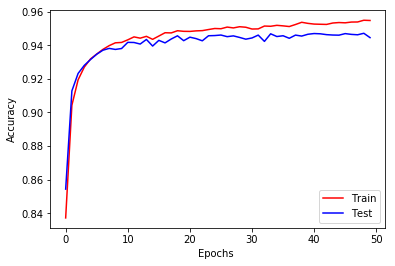

In [33]:
plt.plot(results['training_accuracy'], '-r', label='Train')
plt.plot(results['validation_accuracy'], '-b', label= 'Test')
plt.ylabel('Accuracy')
plt.xlabel('Epochs ')   
plt.legend()
plt.show()


Number of negative cases =  18598
Number of positive cases =  7321
The ratio of Positve to Negative cases is 0.394

Number of Negative Classes is quite large. Recommend using the Precision-Recall Metrics.


Overall Accuracy = 0.945

           CONFUSION MATRIX
                 y_pred
              -1        1     
           --------------------
y_test -1 |  17722      876    |
        1 |   562       6759   |
           --------------------



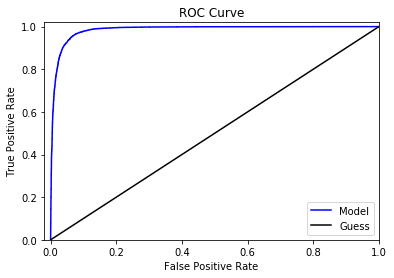

AUC = 0.985



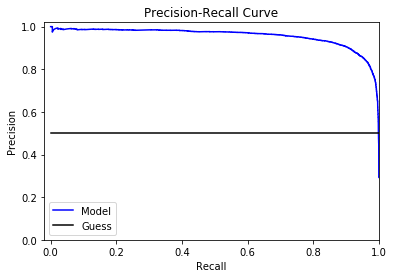

F1 Score = 0.904
MCC = 0.865
AUC for Precision-Recall: 0.957
Average Precision = 0.957


In [34]:
# Look at some 2 Class Accuracy Metrics
model = model
model.eval()
yprob = model(test_set.x)
yprob1 = yprob.data.numpy()
yprob1 = np.exp(yprob1)/np.sum(np.exp(yprob1),axis=1).reshape(-1,1)
yprob1 = yprob1[:,1]
_,ypred = torch.max(yprob,1)
ypred = ypred.data.numpy()
ytest = test_set.y.type(torch.FloatTensor).data.numpy()

metrics = ModelMetrics(ytest,ypred,yprob1)
metrics.all_metrics()

It looks like we are actually doing a pretty good job at capturing the results here! The confusion matrix is not too skewed to predict only background results, with no large bias in the precision and recall. 

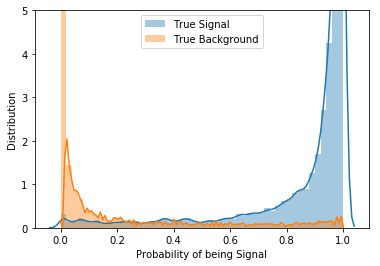

In [35]:
sns.distplot(yprob1[ytest==1],label='True Signal')
sns.distplot(yprob1[ytest==0],label='True Background')
plt.ylim([0,5])
plt.legend(loc='upper center')
plt.xlabel('Probability of being Signal')
plt.ylabel('Distribution')
plt.show()

This seems to be a favourite method of displaying the data within the physics community, so we include it to compare with published results, such as [here](https://arxiv.org/abs/physics/0508045) which creates a decision tree prediction algorithm.